## 12. Seq2seq으로 번역기 만들기 [프로젝트]

In [1]:
import pandas as pd
import tensorflow
import matplotlib

print(pd.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.3
2.6.0
3.4.3


In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.6.0


path_en = './data/korean-english-park.train.en'
path_kor = './data/korean-english-park.train.ko'

raw_kor = pd.read_table(path_kor, header= None)
raw_en = pd.read_table(path_en, header = None)

### 파일 읽어 오기

In [3]:
with open('./data/korean-english-park.train.ko', "r") as f:
    raw_kor = f.read().splitlines()

with open('./data/korean-english-park.train.en', "r") as f:
    raw_en = f.read().splitlines()

print("Data Size:", len(raw_kor))
print("Example:")
for sen in raw_kor[0:100][::20]: print(">>", sen)
    
print("Data Size:", len(raw_en))
print("Example:")
for sen in raw_en[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give th

### Preprocessing

In [4]:
#For korean

import re

def preprocess_sentence_kor(sentence, s_token=False, e_token=False):
    sentence = sentence.strip()

    # Add spaces around punctuation
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # Remove consecutive spaces
    sentence = re.sub(r'[" "]+', " ", sentence)

    # Remove all characters except Korean, spaces, and punctuation
    sentence = re.sub(r"[^가-힣0-9a-zA-Z?.!,]+", " ", sentence)

    # Remove leading/trailing spaces
    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'

    return sentence

In [5]:
#For English

def preprocess_sentence_en(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [6]:
raw_kor[:5], raw_en[:5]

(['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"',
  '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.',
  '그러나 이것은 또한 책상도 필요로 하지 않는다.',
  '79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.',
  '정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.'],
 ['Much of personal computing is about "can you top this?"',
  'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.',
  "Like all optical mice, But it also doesn't need a desk.",
  'uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.',
  "Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack."])

In [7]:
enc_corpus = [preprocess_sentence_kor(line) for line in raw_kor]
dec_corpus = [preprocess_sentence_en(line, s_token = True, e_token = True) for line in raw_en]

print("Korean:", enc_corpus[1])   # go away !
print("English:", dec_corpus[1])   # <start> salga de aqu ! <end>
len(enc_corpus),len(dec_corpus)


Korean: 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다 .
English: <start> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable , wireless mouse . <end>


(94123, 94123)

### 중복 제외

In [8]:
#병렬데이터 중복 제거
cleaned_corpus = set(zip(enc_corpus, dec_corpus))
see = list(cleaned_corpus)
see[:5]

[('한편 일본 정부는 중국정부의 입장을 존중해 이번 티베트 소요에 대해 아무런 언급을 하지 않았다 .',
  '<start> japan s government has been relatively quiet about the violence in tibet and , out of deference to beijing , does not deal officially with the dalai lama . <end>'),
 ('모 아니면 도였지요 라고 말했다 .', '<start> it was all or nothing . <end>'),
 ('단어장 서울대 총장 , 고교평준화 시행 촉구2005 . 08',
  '<start> seoul national university snu president chung un chan on monday urged the government to reconsider its ban on the high school ranking system . <end>'),
 ('고려대학교는 입학 정원으로 120명을 할당받았다 .',
  '<start> korea university was granted a student quota of . <end>'),
 ('단어장 Australia wants Iraq troops home by mid 2008호주 , 이라크 파병 호주군 2008년까지 철군 희망2008 . 06',
  '<start> rudd promised a gradual withdrawal of the troops , but had been coy about setting a timetable for their return to australia . <end>')]

### Tokenizing

In [9]:
from konlpy.tag import Mecab

In [10]:
def sentence_filter(corpus1, corpus2):
    
    MAX_LENGTH = 40
    
    mecab_corpus = []
    m = Mecab()
    
    for sentence in corpus1:
        mecab_corpus.append(m.morphs(sentence))
    
    corpus_en = [s.split() for s in corpus2]
    
    zipped = zip(mecab_corpus, corpus_en)
    zipped_pd = pd.DataFrame(zipped, columns=['Korean', 'English'])
    #tokens_zipped_pd.head()
    
    mask = (zipped_pd['Korean'].str.len() <= MAX_LENGTH) & (zipped_pd['English'].str.len() <= MAX_LENGTH)
    result = zipped_pd[mask]
    
    mecab_corpus = result['Korean']
    corpus_en = result['English']
    
    return mecab_corpus, corpus_en

In [11]:
def tokenize_kor(corpus):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

    #mecab_corpus, corpus_en = sentence_filter(corpus1, corpus2, MAX_LENGTH)   # 문장 길이 40까지 filtering

    tokenizer.fit_on_texts(corpus)
    mecab_tensor = tokenizer.texts_to_sequences(corpus)
    #mecab_tensor = tf.keras.preprocessing.sequence.pad_sequences(mecab_tensor, padding='post', maxlen=max_len)
    mecab_tensor = tf.keras.preprocessing.sequence.pad_sequences(mecab_tensor, padding='post')
    return mecab_tensor, tokenizer



In [12]:
def tokenize_en(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [13]:
cor_kor, cor_en = zip(*cleaned_corpus)

In [14]:
len(cor_kor), len(cor_en), len(cor_kor[0]), len(cor_kor[10]) 

(78930, 78930, 54, 46)

In [15]:
corpus_kor, corpus_en = sentence_filter(cor_kor, cor_en)

In [16]:
len(corpus_kor), len(corpus_en), len(corpus_kor[0]), len(corpus_kor[10]) 

(61503, 61503, 25, 22)

In [17]:
# 토큰화하기
tokens_kor, enc_tokenizer = tokenize_kor(corpus_kor)
tokens_en, dec_tokenizer = tokenize_en(corpus_en)

In [18]:
len(tokens_kor[23]), len(tokens_kor[1]), len(tokens_en[1]), len(tokens_en[1]), len(tokens_kor), len(tokens_en)

(40, 40, 40, 61503, 61503)

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


In [20]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        
    def call(self, x):
        x = self.embedding(x)
        x = self.gru(x)
        return x

In [22]:
# reference
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [23]:
# 코드를 실행하세요.

BATCH_SIZE     = 16#32#64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units )
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (16, 30, 1024)
Decoder Output: (16, 37967)
Decoder Hidden State: (16, 1024)
Attention: (16, 30, 1)


In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [25]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [26]:
tokens_kor.shape

(61503, 40)

In [27]:
from tqdm import tqdm # tqdm 
import random

EPOCHS =10


for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, tokens_kor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(tokens_kor[idx:idx+BATCH_SIZE],
                                tokens_en[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    

Epoch 10: 100%|██████████| 3844/3844 [22:45<00:00,  2.82it/s, Loss 3.5466]


In [29]:
#그래프 한글표현 인스톨?

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


In [37]:
enc_train = tokens_kor
dec_train = tokens_en

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence_kor(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding ='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention




Input: 오늘은 날씨가 제법 선선하네요 . 어제 비가 많이 와서 그런가봐요 .
Predicted translation: the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the 


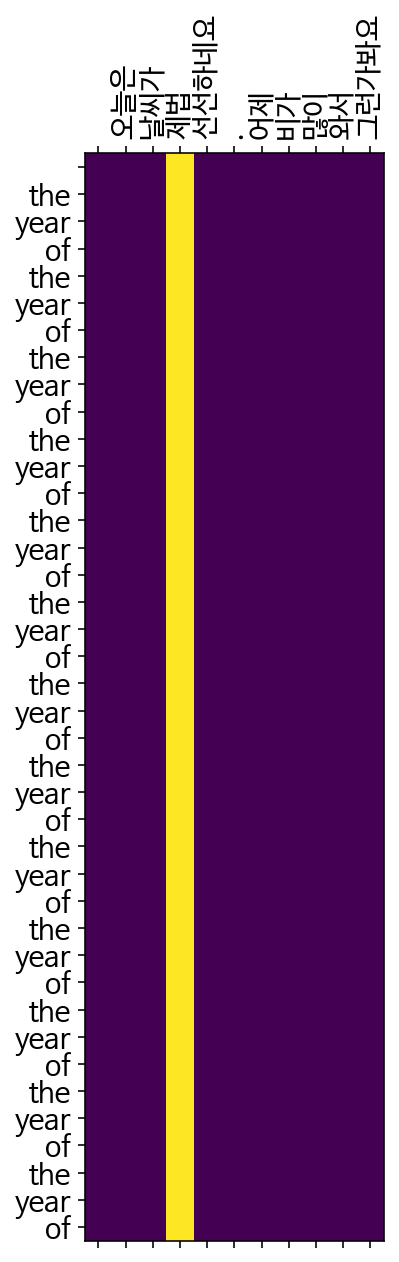

In [39]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}
    
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(sentence) + 1)))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(predicted_sentence) + 1)))
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("오늘은 날씨가 제법 선선하네요. 어제 비가 많이 와서 그런가봐요.", encoder, decoder)